### Learning Objectives

By the end of this tutorial, you will be able to:

- Run SimBa to retrieve similar fact-checked claims for any input sentence
- Interpret SimBa's output and similarity scores
- Customize retrieval and reranking settings
- Plot and analyze the distribution of similarity scores

#### Target Audience

This tutorial is aimed at **beginners with some knowledge of Python** and basic familiarity with terminal commands or Jupyter Notebooks.

#### Setting up the Computational Environment

The following Python packages are required:

In [1]:
!pip install pandas matplotlib nltk


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


You must also install packages listed in SimBa's `requirements.txt`:

In [4]:
!pip install -r H:/detection-of-verified-claims/requirements.txt

  Using cached requests-2.25.1-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0
  Attempting uninstall: requests
    Found existing installation: requests 2.32.5
    Uninstalling requests-2.32.5:
      Successfully uninstalled requests-2.32.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 9.4.0 requires typing_extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.
jupyterlab-server 2.27.3 requires requests>=2.31, but you have requests 2.25.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Duration

Estimated time to complete this tutorial: **20-30 minutes**

#### Social Science Use Case(s)

SimBa has been used in research to support:

- Analysis of misinformation spread in online discourse
- Retrieval of fact-checked claims from large knowledge bases
- Fact-check support for journalistic and academic workflows

> For example, SimBa was evaluated in the CLEF CheckThat! Lab to detect previously verified claims ([Hovelmeyer et al., 2022](https://ceur-ws.org/Vol-3180/paper-40.pdf)).

### SimBa Tutorial: Retrieve Fact-Checks for Your Claims

This Jupyter notebook walks you through how to use **SimBa** to retrieve fact-checked claims similar to a query.
We'll:
- Prepare a query
- Run SimBa with and without cache
- Load and inspect the results
- Plot similarity scores

### Setup: Configure Your SimBa Path

**IMPORTANT**: Update the path below to point to your SimBa installation directory.

In [9]:
# UPDATE THIS PATH to match your SimBa installation
import os
import sys

# Option 1: If SimBa is in your current directory
simba_dir = "H:/detection-of-verified-claims"

# Option 2: If SimBa is elsewhere, update this path
# simba_dir = "/path/to/your/detection-of-verified-claims"
# simba_dir = "C:/Users/YourName/detection-of-verified-claims"  # Windows
# simba_dir = "/home/yourname/detection-of-verified-claims"     # Linux

print(f"Looking for SimBa at: {os.path.abspath(simba_dir)}")

if os.path.exists(simba_dir):
    sys.path.append(simba_dir)
    os.chdir(simba_dir)
    print(f"Successfully changed to SimBa directory: {os.getcwd()}")
else:
    print(f"ERROR: SimBa directory not found at {os.path.abspath(simba_dir)}")
    print("Please update the 'simba_dir' variable above with the correct path.")

Looking for SimBa at: H:\detection-of-verified-claims
Successfully changed to SimBa directory: H:\detection-of-verified-claims


### Check SimBa Installation

In [10]:
import subprocess

# Check SimBa structure
def check_simba_structure():
    required_files = [
        "src/candidate_retrieval/retrieval.py",
        "src/re_ranking/re_ranking.py",
        "data/claimsKG/corpus.tsv"
    ]
    
    print("Checking SimBa structure:")
    all_exist = True
    for file_path in required_files:
        exists = os.path.exists(file_path)
        print(f"  {'✓' if exists else '✗'} {file_path}: {exists}")
        if not exists:
            all_exist = False
    
    return all_exist

# Check structure
structure_ok = check_simba_structure()

if not structure_ok:
    print("\nERROR: Some required SimBa files are missing.")
    print("Please ensure you have the complete SimBa installation.")
else:
    print("\n✓ SimBa structure looks good!")

Checking SimBa structure:
  ✓ src/candidate_retrieval/retrieval.py: True
  ✓ src/re_ranking/re_ranking.py: True
  ✓ data/claimsKG/corpus.tsv: True

✓ SimBa structure looks good!


### Create Sample Query

In [11]:
# Create queries file if needed
queries_file = "data/mydata/queries.tsv"
print(f"Queries file: {queries_file} - {'✓' if os.path.exists(queries_file) else '✗'}")

if not os.path.exists(queries_file):
    print("Creating queries file...")
    os.makedirs("data/mydata", exist_ok=True)
    query = "Covid-19 vaccines increase the risk of dying from the new Covid-19 variants"
    with open(queries_file, "w", encoding="utf-8") as f:
        f.write("1\t" + query + "\n")
    print("✓ Queries file created")
else:
    # Show existing query
    with open(queries_file, "r", encoding="utf-8") as f:
        content = f.read().strip()
        query = content.split('\t')[1] if '\t' in content else content
    print(f"Using existing query: '{query}'")

Queries file: data/mydata/queries.tsv - ✓
Using existing query: '"Covid-19 vaccines increase the risk of dying from the new Covid-19 variants"'


### Run SimBa Analysis

In [14]:
def run_simba_analysis(dataset_name, database_name="claimsKG", use_cache=True):
    print(f"Running SimBa Analysis...")
    print(f"Dataset: {dataset_name}")
    print(f"Database: {database_name}")
    print(f"Use cache: {use_cache}")
    
    # Input files
    data_name_queries = f"data/{dataset_name}/queries.tsv"
    data_name_targets = f"data/{database_name}/corpus.tsv"
    
    print(f"\nInput files:")
    print(f"  Queries: {data_name_queries} - {'✓' if os.path.exists(data_name_queries) else '✗'}")
    print(f"  Targets: {data_name_targets} - {'✓' if os.path.exists(data_name_targets) else '✗'}")
    
    if not os.path.exists(data_name_queries) or not os.path.exists(data_name_targets):
        print("Missing queries or claims database file!")
        return False
    
    # Handle cache
    caching_directory = os.path.join("data", "cache", dataset_name)
    if not use_cache and os.path.exists(caching_directory):
        import shutil
        shutil.rmtree(caching_directory)
        print(f"Cleared cache: {caching_directory}")
    elif use_cache:
        print(f"Using cache if available at: {caching_directory}")
    
    # Candidate retrieval
    retrieval_command = [
        "python", "src/candidate_retrieval/retrieval.py",
        data_name_queries, data_name_targets,
        dataset_name, dataset_name, "braycurtis", "50",
        "-sentence_embedding_models", "all-mpnet-base-v2"
    ]
    
    print(f"\nRunning candidate retrieval...")
    try:
        result = subprocess.run(retrieval_command, capture_output=True, text=True, timeout=3600)
        if result.returncode != 0:
            print(f"Candidate retrieval failed: {result.stderr}")
            return False
        print("Candidate retrieval completed")
    except Exception as e:
        print(f"Error during candidate retrieval: {e}")
        return False
    
    # Re-ranking
    reranking_command = [
        "python", "src/re_ranking/re_ranking.py",
        data_name_queries, data_name_targets,
        dataset_name, dataset_name, "braycurtis", "5",
        "-sentence_embedding_models",
        "all-mpnet-base-v2", "sentence-transformers/sentence-t5-base",
        "princeton-nlp/unsup-simcse-roberta-base",
        "-lexical_similarity_measures", "similar_words_ratio"
    ]
    
    print(f"Running re-ranking...")
    try:
        result = subprocess.run(reranking_command, capture_output=True, text=True, timeout=3600)
        if result.returncode != 0:
            print(f"Re-ranking failed: {result.stderr}")
            return False
        print("Re-ranking completed")
    except Exception as e:
        print(f"Error during re-ranking: {e}")
        return False
    
    # Check outputs
    output_dir = f"data/{dataset_name}"
    if os.path.exists(output_dir):
        print(f"\nOutput files created in {output_dir}:")
        for file in os.listdir(output_dir):
            print(f"  {file}")
    
    return True

# Execute the function (this code should be outside the function definition)
if structure_ok:
    success = run_simba_analysis("mydata", "claimsKG", use_cache=False)
    if success:
        print("\nSimBa analysis completed successfully!")
    else:
        print("\nAnalysis failed. Check the error messages above.")
else:
    print("Cannot run SimBa - missing required files")

Running SimBa Analysis...
Dataset: mydata
Database: claimsKG
Use cache: False

Input files:
  Queries: data/mydata/queries.tsv - ✓
  Targets: data/claimsKG/corpus.tsv - ✓
Cleared cache: data\cache\mydata

Running candidate retrieval...
Candidate retrieval completed
Running re-ranking...
Re-ranking completed

Output files created in data/mydata:
  candidates.pickle.zip
  pred_client.tsv
  pred_qrels.tsv
  queries.tsv

SimBa analysis completed successfully!


### Load and Inspect Results

In [15]:
import pandas as pd
from IPython.display import display, HTML

# Load the results
output_files = [
    "data/mydata/pred_client.tsv",  # Client-formatted results
    "data/mydata/pred_qrels.tsv",   # Main results file
]

results_df = None
for file_path in output_files:
    if os.path.exists(file_path):
        print(f"Loading results from: {file_path}")
        try:
            results_df = pd.read_csv(file_path, sep="\t")
            print(f"Shape: {results_df.shape}")
            print(f"Columns: {list(results_df.columns)}")
            break
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

if results_df is None:
    print("No results file found. Check the data/mydata directory.")
    if os.path.exists("data/mydata"):
        print("Available files:")
        for file in os.listdir("data/mydata"):
            print(f"  - {file}")
else:
    # Create HTML version with clickable links
    def make_clickable(url):
        if pd.isna(url):
            return url
        return f'<a href="{url}" target="_blank">{url}</a>'
    
    display_df = results_df.copy()
    
    # Make URLs clickable if they exist
    if 'claimReviewURL' in display_df.columns:
        display_df['claimReviewURL'] = display_df['claimReviewURL'].apply(make_clickable)
    
    print("\nSimBa Results Table:")
    display(HTML(display_df.to_html(escape=False, index=False)))

Loading results from: data/mydata/pred_client.tsv
Shape: (5, 5)
Columns: ['query', 'vclaim', 'claimReviewURL', 'rating', 'similarity']

SimBa Results Table:


query,vclaim,claimReviewURL,rating,similarity
Covid-19 vaccines increase the risk of dying from the new Covid-19 variants,Vaccinated people are more susceptible to Covid-19 variants,https://factcheck.afp.com/http%253A%252F%252Fdoc.afp.com%252F9PB64D-1,b'False',51.249025
Covid-19 vaccines increase the risk of dying from the new Covid-19 variants,Covid-19 vaccines will leave people exposed to deadly illness during the next cold and flu season and germ theory is a hoax,https://factcheck.afp.com/covid-19-shots-not-designed-increase-cold-flu-lethality,b'False',51.102840
Covid-19 vaccines increase the risk of dying from the new Covid-19 variants,Getting the first dose of Covid-19 vaccine increases risk of catching the novel coronavirus,https://factcheck.afp.com/misleading-facebook-posts-claim-covid-19-vaccine-increases-risk-catching-novel-coronavirus,b'Misleading',50.774386
Covid-19 vaccines increase the risk of dying from the new Covid-19 variants,People vaccinated against Covid-19 pose a health risk to others by shedding spike proteins,https://factcheck.afp.com/covid-19-vaccine-does-not-make-people-dangerous-others,b'False',49.871481
Covid-19 vaccines increase the risk of dying from the new Covid-19 variants,Mass vaccination will cause monster Covid-19 variants,https://factcheck.afp.com/mass-covid-19-vaccination-will-not-lead-out-control-variants,b'False',49.756611


### Plot Similarity Score Distribution

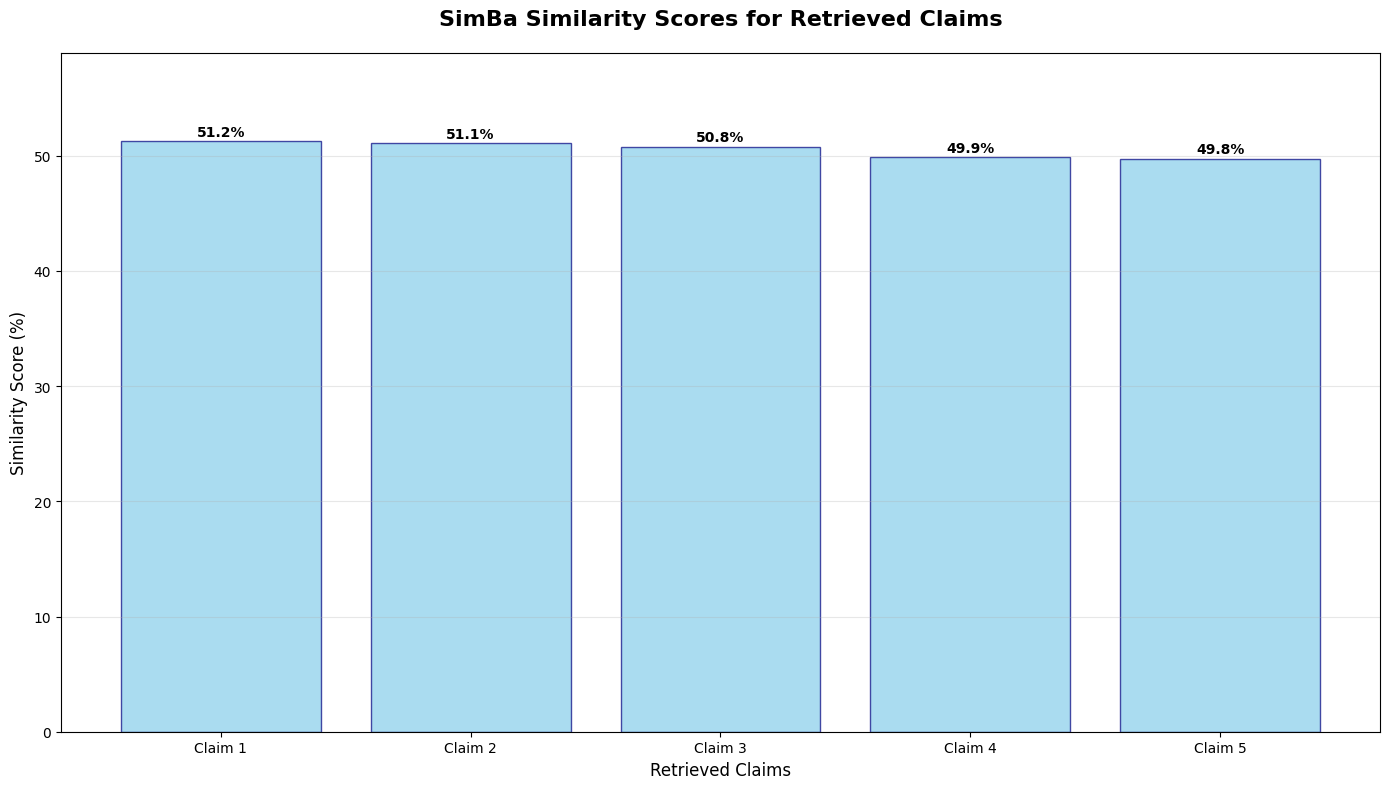


Similarity Scores Summary:
51.25%  |  Vaccinated people are more susceptible to Covid-19 variants
         Rating: b'False'

51.10%  |  Covid-19 vaccines will leave people exposed to deadly illness during the next co...
         Rating: b'False'

50.77%  |  Getting the first dose of Covid-19 vaccine increases risk of catching the novel ...
         Rating: b'Misleading'

49.87%  |  People vaccinated against Covid-19 pose a health risk to others by shedding spik...
         Rating: b'False'

49.76%  |  Mass vaccination will cause monster Covid-19 variants
         Rating: b'False'

Statistics:
  Highest score: 51.25%
  Lowest score:  49.76%
  Average score: 50.55%
  Score range:   1.49%


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

if results_df is not None and 'similarity' in results_df.columns:
    # Convert similarity to numeric
    results_df['similarity'] = pd.to_numeric(results_df['similarity'], errors='coerce')
    
    # Create visualization
    plt.figure(figsize=(14, 8))
    
    # Create meaningful labels
    claim_labels = [f"Claim {i+1}" for i in range(len(results_df))]
    bars = plt.bar(claim_labels, results_df['similarity'], 
                   color='skyblue', edgecolor='navy', alpha=0.7, linewidth=1)
    
    # Customize the chart
    plt.title("SimBa Similarity Scores for Retrieved Claims", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Retrieved Claims", fontsize=12)
    plt.ylabel("Similarity Score (%)", fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                f'{height:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    # Styling
    plt.xticks(rotation=0)
    plt.ylim(0, max(results_df['similarity']) * 1.15)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSimilarity Scores Summary:")
    print("=" * 50)
    for i, row in results_df.iterrows():
        claim_text = row['vclaim'][:80] + "..." if len(str(row['vclaim'])) > 80 else row['vclaim']
        print(f"{row['similarity']:.2f}%  |  {claim_text}")
        if 'rating' in row:
            print(f"         Rating: {row['rating']}")
        print()
    
    print("Statistics:")
    print(f"  Highest score: {results_df['similarity'].max():.2f}%")
    print(f"  Lowest score:  {results_df['similarity'].min():.2f}%")
    print(f"  Average score: {results_df['similarity'].mean():.2f}%")
    print(f"  Score range:   {results_df['similarity'].max() - results_df['similarity'].min():.2f}%")

else:
    print("No similarity data available to plot.")
    if results_df is not None:
        print("Available columns:", results_df.columns.tolist())
    else:
        print("No results loaded. Run the previous cells first.")